# Model Comparison
### Predicting the age of abalone using KNN and linear regression.

The [Data](http://archive.ics.uci.edu/ml/datasets/Abalone) contains various physical measurements of abalone as well as the age. It comes from the UCI machine learning repository. 

In [187]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import neighbors
import seaborn as sns
from sklearn.model_selection import cross_val_score
import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

pd.options.display.float_format = '{:.3f}'.format

%matplotlib inline

In [188]:
df = pd.read_csv('abalone.csv')

In [189]:
df.columns = ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']
print(df.shape)
df.head()

(4176, 9)


,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.350,0.265,0.090,0.226,0.100,0.049,0.070,7
1,F,0.530,0.420,0.135,0.677,0.257,0.141,0.210,9
2,M,0.440,0.365,0.125,0.516,0.215,0.114,0.155,10
3,I,0.330,0.255,0.080,0.205,0.089,0.040,0.055,7
4,I,0.425,0.300,0.095,0.351,0.141,0.077,0.120,8


## Explore the data

In [190]:
df.describe()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
count,4176.000,4176.000,4176.000,4176.000,4176.000,4176.000,4176.000,4176.000
mean,0.524,0.408,0.140,0.829,0.359,0.181,0.239,9.932
std,0.120,0.099,0.042,0.490,0.222,0.110,0.139,3.224
min,0.075,0.055,0.000,0.002,0.001,0.001,0.002,1.000
25%,0.450,0.350,0.115,0.442,0.186,0.093,0.130,8.000
50%,0.545,0.425,0.140,0.800,0.336,0.171,0.234,9.000
75%,0.615,0.480,0.165,1.153,0.502,0.253,0.329,11.000
max,0.815,0.650,1.130,2.825,1.488,0.760,1.005,29.000


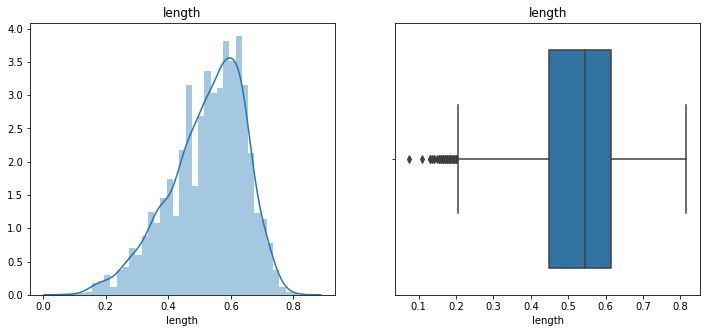

In [191]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.distplot(df['length'])
plt.title('length')

plt.subplot(1, 2, 2)
sns.boxplot(df['length'])
plt.title('length')

plt.show()

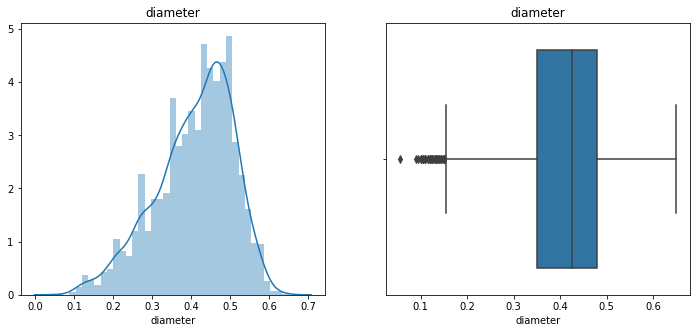

In [192]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.distplot(df['diameter'])
plt.title('diameter')

plt.subplot(1, 2, 2)
sns.boxplot(df['diameter'])
plt.title('diameter')

plt.show()

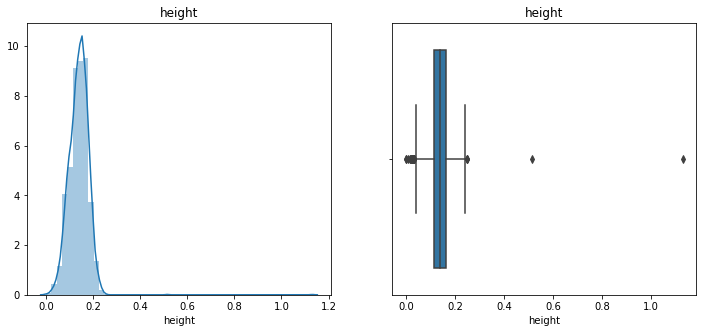

In [193]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.distplot(df['height'])
plt.title('height')

plt.subplot(1, 2, 2)
sns.boxplot(df['height'])
plt.title('height')

plt.show()

In [194]:
df = df[df['height'] < .4]

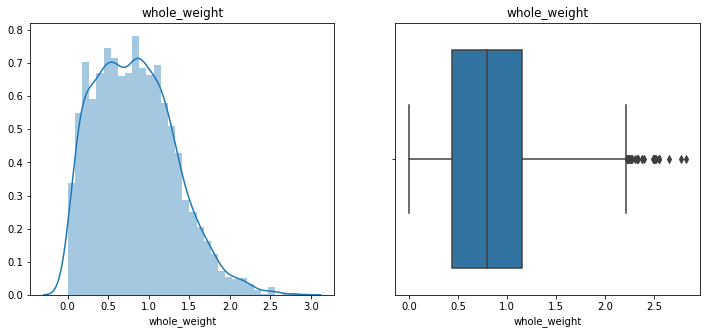

In [195]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.distplot(df['whole_weight'])
plt.title('whole_weight')

plt.subplot(1, 2, 2)
sns.boxplot(df['whole_weight'])
plt.title('whole_weight')

plt.show()

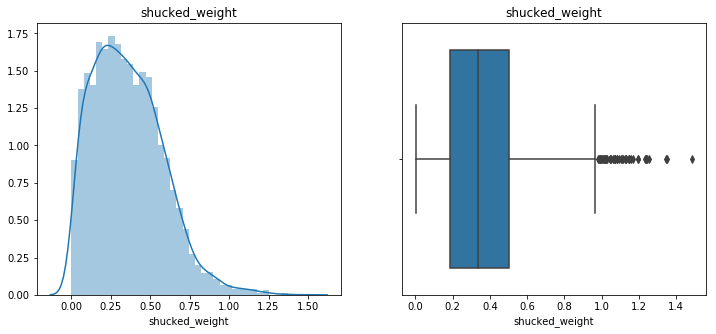

In [196]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.distplot(df['shucked_weight'])
plt.title('shucked_weight')

plt.subplot(1, 2, 2)
sns.boxplot(df['shucked_weight'])
plt.title('shucked_weight')

plt.show()

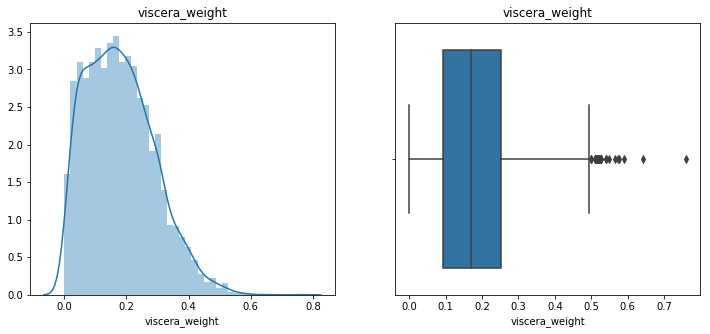

In [197]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.distplot(df['viscera_weight'])
plt.title('viscera_weight')

plt.subplot(1, 2, 2)
sns.boxplot(df['viscera_weight'])
plt.title('viscera_weight')

plt.show()

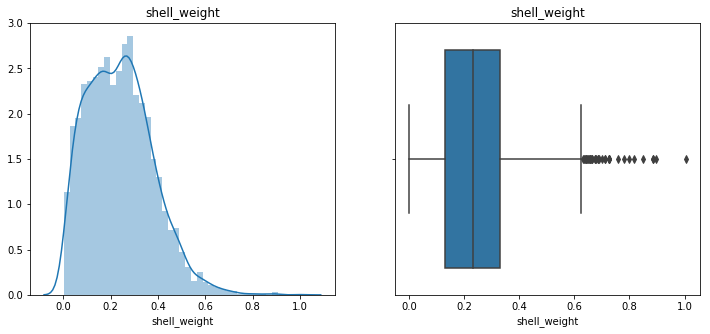

In [198]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.distplot(df['shell_weight'])
plt.title('shell_weight')

plt.subplot(1, 2, 2)
sns.boxplot(df['shell_weight'])
plt.title('shell_weight')

plt.show()

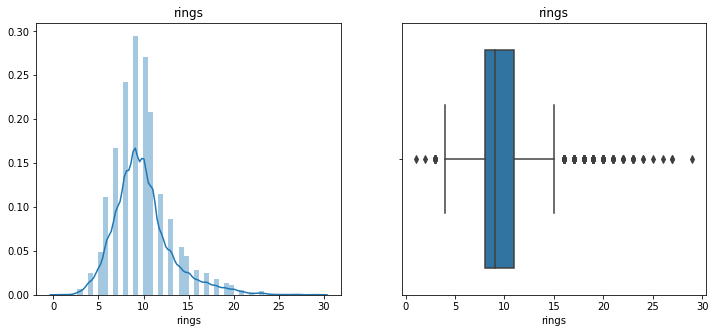

In [199]:
#Age is rings + 1.5
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.distplot(df['rings'])
plt.title('rings')

plt.subplot(1, 2, 2)
sns.boxplot(df['rings'])
plt.title('rings')

plt.show()

In [200]:
#Add dummies for sex column
sexes = pd.get_dummies(df['sex'])
df = pd.concat([df, sexes], axis = 1)
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,F,I,M
0,M,0.350,0.265,0.090,0.226,0.100,0.049,0.070,7,0,0,1
1,F,0.530,0.420,0.135,0.677,0.257,0.141,0.210,9,1,0,0
2,M,0.440,0.365,0.125,0.516,0.215,0.114,0.155,10,0,0,1
3,I,0.330,0.255,0.080,0.205,0.089,0.040,0.055,7,0,1,0
4,I,0.425,0.300,0.095,0.351,0.141,0.077,0.120,8,0,1,0


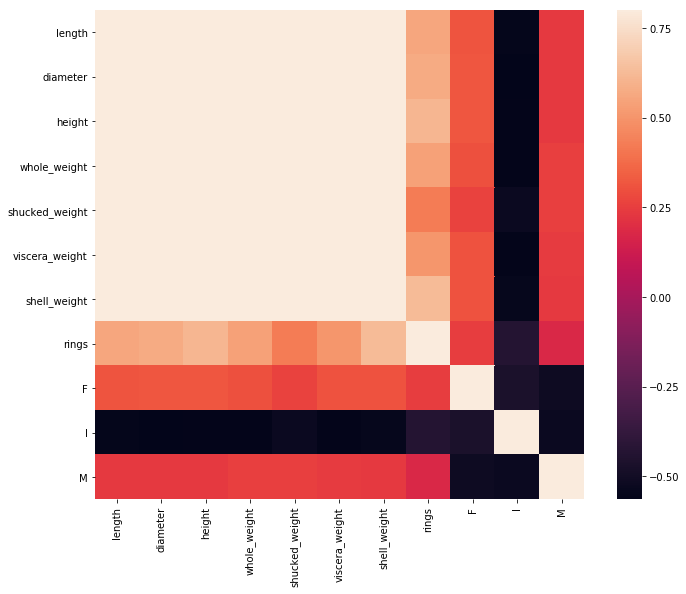

In [201]:
corrmat = df.corr()

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

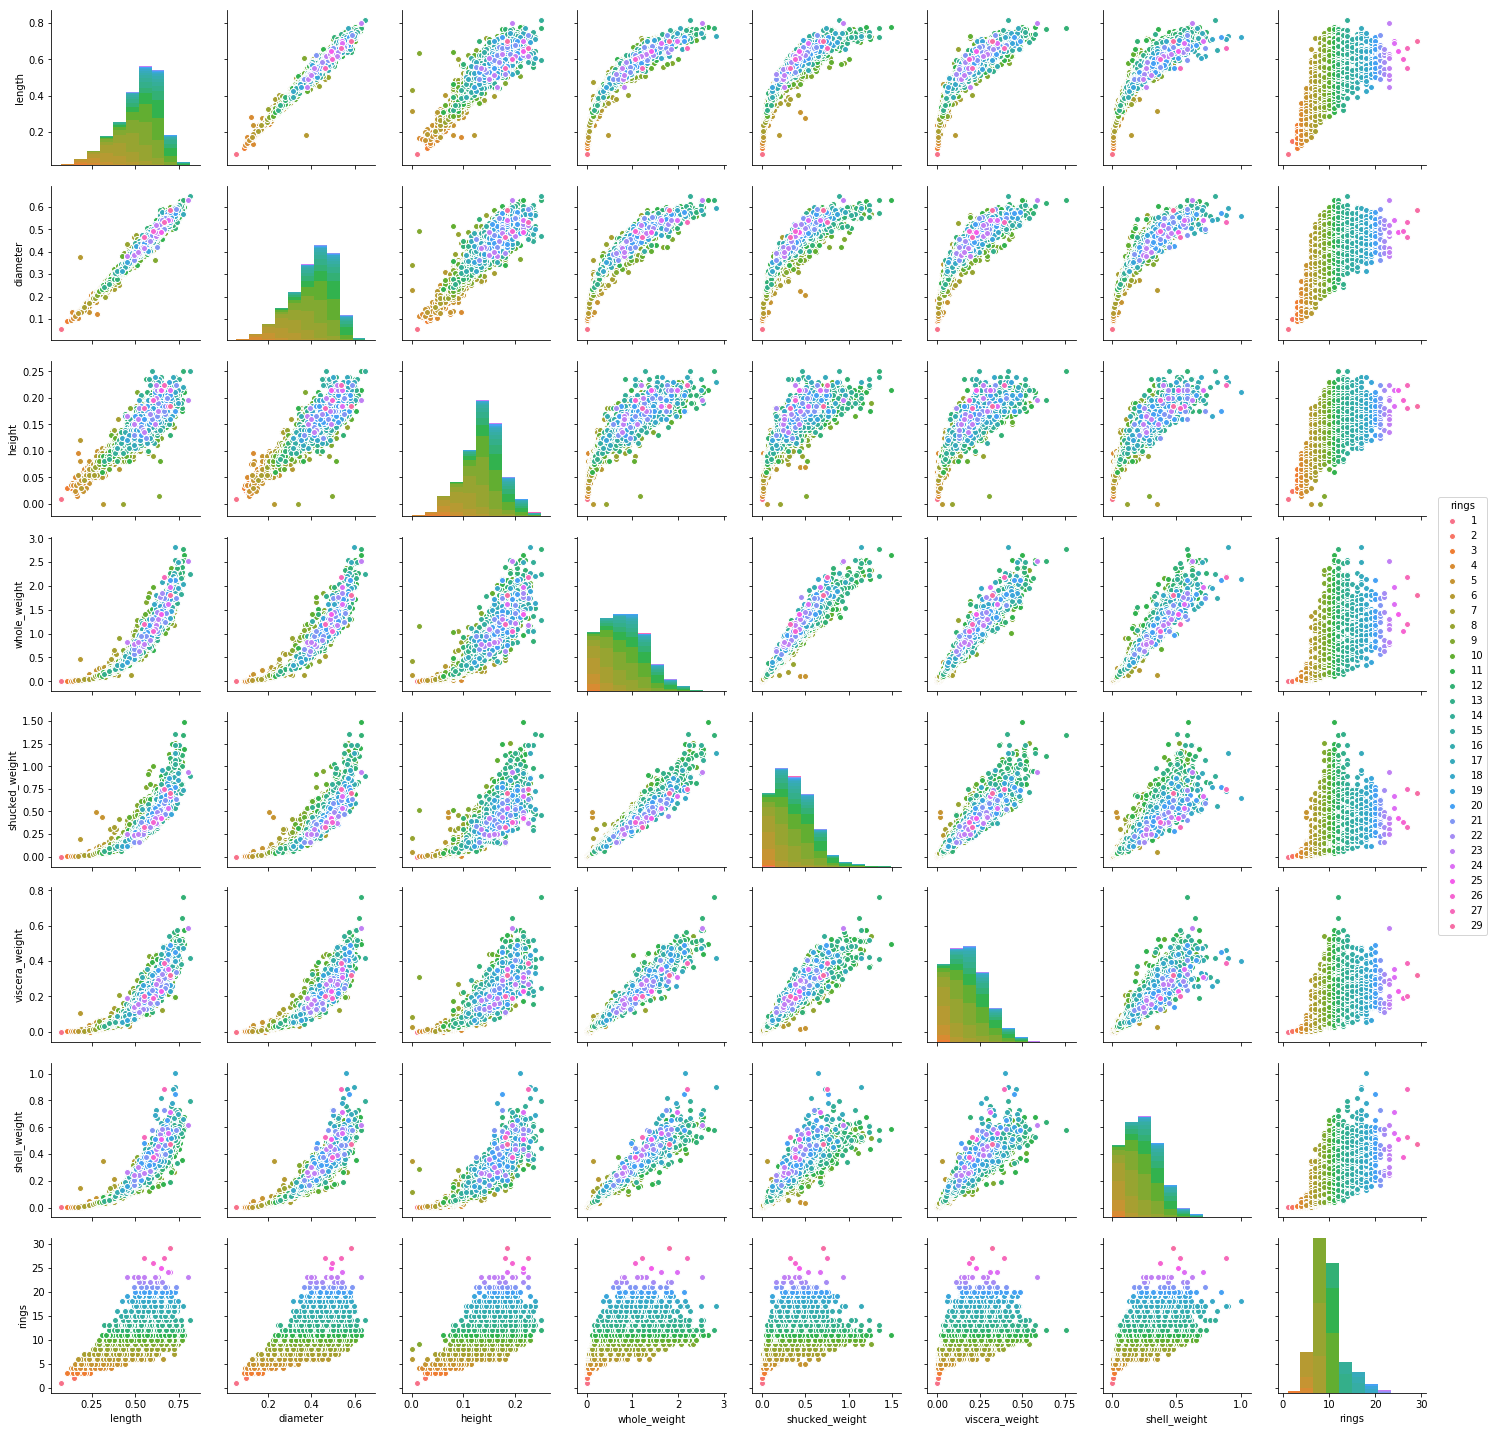

In [109]:
sns.pairplot(df, hue="rings")

# KNN regression model

## Finding K

In [202]:
X = df[['length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'F', 'I', 'M']]
Y = df['rings']

## Unweighted

In [203]:
# Unweighted 
k_values = []
for i in range(1, 500):
    knn = neighbors.KNeighborsRegressor(n_neighbors=i)
    knn.fit(X, Y)
    mean_r2 = cross_val_score(knn, X, Y, cv=5).mean()
    k_values.append([i, mean_r2])

k_values = pd.DataFrame(k_values)
k_values.head()

,0,1
0,1,0.063
1,2,0.276
2,3,0.372
3,4,0.408
4,5,0.428


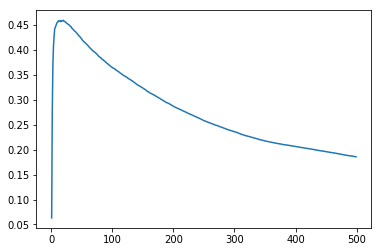

In [204]:
k_values.columns = ['k', 'r_squared']
plt.plot(k_values.k, k_values.r_squared)

In [205]:
k_values[k_values.r_squared == k_values.r_squared.max()]

,k,r_squared
19,20,0.460


## Weighted

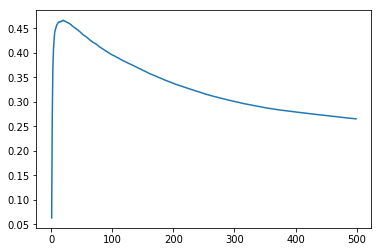

In [206]:
# weighted 
kw_values = []
for i in range(1, 500):
    knn_w = neighbors.KNeighborsRegressor(n_neighbors=i, weights='distance')
    knn_w.fit(X, Y)
    mean_r2 = cross_val_score(knn_w, X, Y, cv=5).mean()
    kw_values.append([i, mean_r2])

kw_values = pd.DataFrame(kw_values)
kw_values.columns = ['k', 'r_squared']
plt.plot(kw_values.k, kw_values.r_squared)

In [207]:
kw_values[kw_values.r_squared == kw_values.r_squared.max()]

,k,r_squared
19,20,0.466


In [213]:
#Based on the plots, a k of 20 with distance weights has the highest average r_squared
#Instantiate and fit model
knn_w = neighbors.KNeighborsRegressor(n_neighbors=20, weights='distance')
knn_w.fit(X, Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=20, p=2,
          weights='distance')

In [214]:
#cross validation
cross_val_score(knn_w, X, Y, cv=10)
# Below scores are inconsistent. The model seems to be overfitting 

array([ 0.48204496,  0.31476131,  0.4584155 ,  0.31835364,  0.46248549,
        0.41886299,  0.53136329,  0.4462221 ,  0.57969136,  0.51449002])

# Linear regresion model

In [215]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
regr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [216]:
# Print coefficients, Y Intercept and R-squared
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ -1.11155666   9.14632148  23.42166098   8.84685616 -19.38140609
 -11.10133156   7.69158687   0.2445941   -0.54138743   0.29679333]

Intercept: 
 3.31349403917

R-squared:
0.544431293781


In [217]:
#cross validation
cross_val_score(regr, X, Y, cv=10)
# Really poor cross val scores

array([ 0.60316157,  0.35532017,  0.31362528,  0.04579948,  0.24823198,
        0.51083342,  0.31498708,  0.47725784,  0.45576362,  0.46651115])

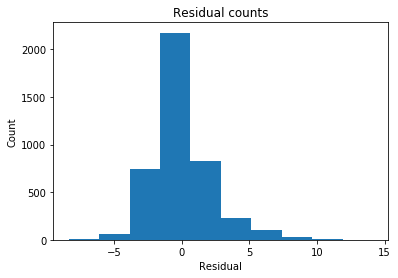

In [218]:
# Examine the distribution of the error.
predicted = regr.predict(X).ravel()
actual = df['rings']

# Calculate the error, also called the residual.
residual = actual - predicted


plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

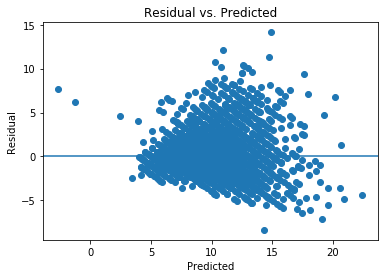

In [219]:
# Examine the homoscedasticity of the initial model
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()


In [222]:
import statsmodels.formula.api as smf
from scipy import stats

data = df[['length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight','M', 'F', 'I', 'rings']]

#Specify interaction
linear_formula = 'rings ~ M+F+I+length+diameter+height+whole_weight+shucked_weight+viscera_weight+shell_weight'

# Run model and print results
lm = smf.ols(formula=linear_formula, data=data).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  rings   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     552.9
Date:                Sun, 03 Jun 2018   Prob (F-statistic):               0.00
Time:                        16:08:44   Log-Likelihood:                -9167.8
No. Observations:                4174   AIC:                         1.836e+04
Df Residuals:                    4164   BIC:                         1.842e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.4851      0.208     11.

In [223]:
#lenght has p-value of .537 so we will drop that
linear_formula = 'rings ~ M+F+I+diameter+height+whole_weight+shucked_weight+viscera_weight+shell_weight'

# Run model and print results
lm = smf.ols(formula=linear_formula, data=data).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  rings   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     622.1
Date:                Sun, 03 Jun 2018   Prob (F-statistic):               0.00
Time:                        16:09:23   Log-Likelihood:                -9168.0
No. Observations:                4174   AIC:                         1.835e+04
Df Residuals:                    4165   BIC:                         1.841e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.4411      0.195     12.

#### Dropping just length didn't do much. Let's try to drop some of the other variables as well.
# Dropping Length, whole weight, shucked weight, viscera weight

In [224]:
X = df[['M', 'F', 'I', 'diameter', 'height', 'shell_weight']]
regr = linear_model.LinearRegression()
regr.fit(X, Y)
# Print coefficients, Y Intercept and R-squared
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ -2.78237951e+13  -2.78237951e+13  -2.78237951e+13  -5.66281953e+00
   2.42105800e+01   1.07010356e+01]

Intercept: 
 2.78237951274e+13

R-squared:
0.419988705311


In [225]:
cross_val_score(regr, X, Y, cv=10)
# Still bad

array([ 0.47175235,  0.1109671 ,  0.04637875,  0.05691726,  0.14027824,
        0.32959816,  0.09635586,  0.37625761,  0.30077441,  0.35280279])

### That reduced performance, let's try normalizing the data.

In [234]:
from sklearn import preprocessing

x = df.drop(['sex'], axis=1).values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled)
df_scaled.columns = [ 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings', 'F', 'I', 'M']

In [235]:
df_scaled.head()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,F,I,M
0,0.372,0.353,0.360,0.079,0.066,0.063,0.068,0.214,0.000,0.000,1.000
1,0.615,0.613,0.540,0.239,0.172,0.186,0.208,0.286,1.000,0.000,0.000
2,0.493,0.521,0.500,0.182,0.144,0.149,0.153,0.321,0.000,0.000,1.000
3,0.345,0.336,0.320,0.072,0.060,0.051,0.053,0.214,0.000,1.000,0.000
4,0.473,0.412,0.380,0.124,0.094,0.101,0.118,0.250,0.000,1.000,0.000


In [236]:
X = df_scaled[['length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'F', 'I', 'M']]
Y = df_scaled['rings']
regr = linear_model.LinearRegression()
regr.fit(X, Y)
# Print coefficients, Y Intercept and R-squared
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [-0.02937685  0.19435933  0.20912197  0.89211066 -1.0292911  -0.30112362
  0.27566098  0.0087355  -0.01933527  0.01059976]

Intercept: 
 0.097766928292

R-squared:
0.544431293781


In [237]:
cross_val_score(regr, X, Y, cv=10)

array([ 0.60498868,  0.35532017,  0.31362528,  0.04579948,  0.24823198,
        0.51083342,  0.31498708,  0.47725784,  0.45576362,  0.46651115])

#### Normalizing the data doesn't seem to help, either.
# PCA


Covariance Matrix:
 [[ 1.00023964  0.98704205  0.90006979  0.92558729  0.89839079  0.90329984
   0.89785483  0.3103187  -0.55182563  0.23639882]
 [ 0.98704205  1.00023964  0.90634751  0.92575891  0.89359546  0.8999859
   0.90548647  0.31931001 -0.56464582  0.24017535]
 [ 0.90006979  0.90634751  1.00023964  0.88793171  0.83660201  0.86590923
   0.88920103  0.31687931 -0.55831324  0.23637418]
 [ 0.92558729  0.92575891  0.88793171  1.00023964  0.96961535  0.9665395
   0.95560953  0.30075478 -0.5581142   0.25170544]
 [ 0.89839079  0.89359546  0.83660201  0.96961535  1.00023964  0.93208615
   0.88288168  0.26501641 -0.52235582  0.25143463]
 [ 0.90329984  0.8999859   0.86590923  0.9665395   0.93208615  1.00023964
   0.90781107  0.30949677 -0.55664291  0.241862  ]
 [ 0.89785483  0.90548647  0.88920103  0.95560953  0.88288168  0.90781107
   1.00023964  0.30716734 -0.54740069  0.23514152]
 [ 0.3103187   0.31931001  0.31687931  0.30075478  0.26501641  0.30949677
   0.30716734  1.00023964 -0.4646

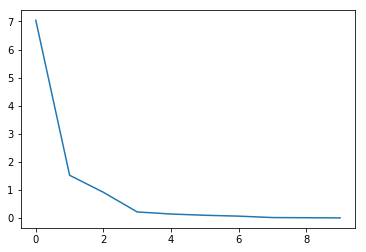

In [238]:
# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X = StandardScaler().fit_transform(X)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
plt.plot(eig_val_cov)
plt.show()

In [239]:
sklearn_pca = PCA(n_components=3)
Y_sklearn = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [ 0.70408612  0.15194089  0.09117021]


In [240]:
pca_component = pd.DataFrame(data = Y_sklearn, columns = ['principal component 1', 'principal component 2', 'principal component 3'])

X = pca_component
regr = linear_model.LinearRegression()
regr.fit(X, Y)
# Print coefficients, Y Intercept and R-squared
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 0.02525853 -0.00135779 -0.00945091]

Intercept: 
 0.319032788007

R-squared:
0.34520495407


In [241]:
cross_val_score(regr, X, Y, cv=10)

array([ 0.36545589,  0.03729159, -0.13706502,  0.04280401,  0.18461409,
        0.19184677, -0.1112859 ,  0.30075149,  0.24075104,  0.30879954])

In [242]:
#Trying the PCA component on the KNN model
knn_w = neighbors.KNeighborsRegressor(n_neighbors=22, weights='distance')
knn_w.fit(X, Y)
cross_val_score(knn_w, X, Y, cv=10)

array([ 0.33587815,  0.11748923, -0.00201455,  0.01477929,  0.16210409,
        0.25162691,  0.07175311,  0.33351353,  0.33605506,  0.35061182])

# Discussion

The KNN model didn't do a very good job at predicting the age of the abalone. To tune the model, a for loop was used to find the best k value, and if weighting should be used. With or without weights, the k value that produced the highest mean cross validation score was 20. Overall the R squared values were low and inconsistant.

The linear regression model did a similarly poor job at predicting the age of the abalone, and seemed to suffer more from over fitting with cross validation scores with higher variance than the KNN model. Neither the score or the over fitting issue seemed to be improved by performing PCA or normalizing the values.  

I prefer the linear regression model because it is much more informative. It was easy to see what features were not significant, and how each feature is effecting the outcome. Even though it seemed to over fit more than the KNN model, this information could be insightful for improving the model. The KNN model, while tune-able, doesn't provide the same level of feedback. 
